## Stock Price Prediction Project using TensorFlow

### Importing Libraries and Dataset

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import seaborn as sns 
import os 
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler

import warnings 
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../data/all_stocks_5yr.csv') 
print(data.shape) 
print(data.sample(7))

(619040, 7)
              date    open    high       low   close   volume  Name
468305  2015-04-13   78.45   78.48   76.4300   76.93  3996764   PSX
460103  2017-09-13   64.26   64.94   64.1545   64.54   578721   PNR
601683  2014-03-06   74.84   76.32   74.7500   75.74  1332199   WYN
150815  2016-03-28   60.25   60.73   59.9200   60.18  3253229  CTSH
515880  2013-07-08  159.86  161.22  159.0300  159.22  1213831   SPG
295424  2017-09-19  144.40  144.72  143.7650  144.62   159387   IFF
135554  2017-07-06   24.95   24.99   24.0150   24.26  8985592   COG


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [4]:
data['date'] = pd.to_datetime(data['date']) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


### Exploratory Data Analysis

Consider a few companies and visualize the distribution of open and closed Stock prices through 5 years.

In [5]:
company_high = data.groupby('Name').max('high').sort_values(by='high', ascending=False)
companies = list(company_high.index[:3]) + list(company_high.index[-6:])
print(companies)

['PCLN', 'AMZN', 'GOOGL', 'NWSA', 'NWS', 'F', 'HBAN', 'AES', 'AMD']


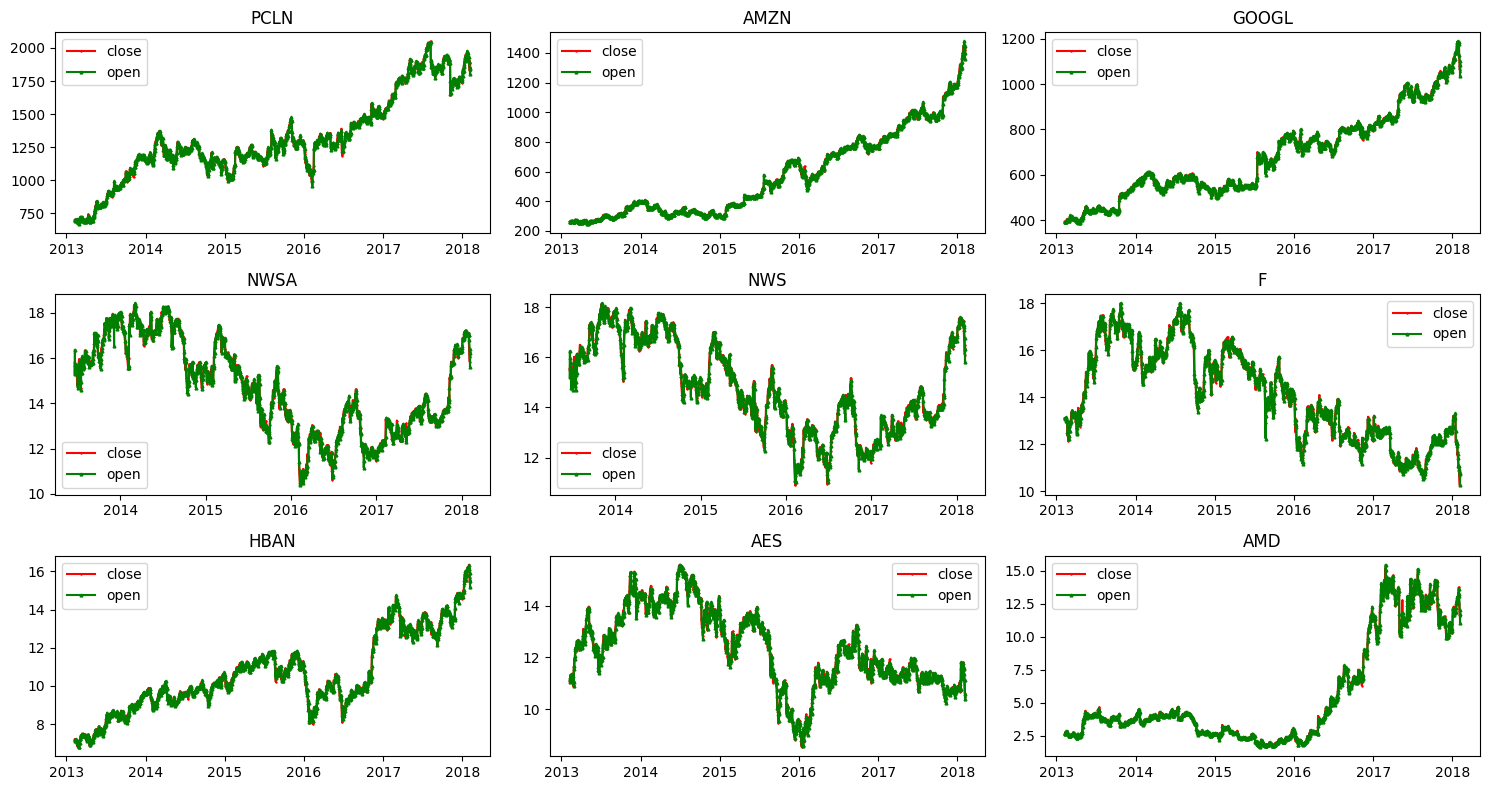

In [6]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies):
    plt.subplot(3, 3, index+1)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c="r", label="close", marker="+", markersize=2)
    plt.plot(c['date'], c['open'], c="g", label="open", marker="^", markersize=2)
    plt.title(company)
    plt.legend()
    plt.tight_layout()

Plot the volume of trade for the same companies as a function of time

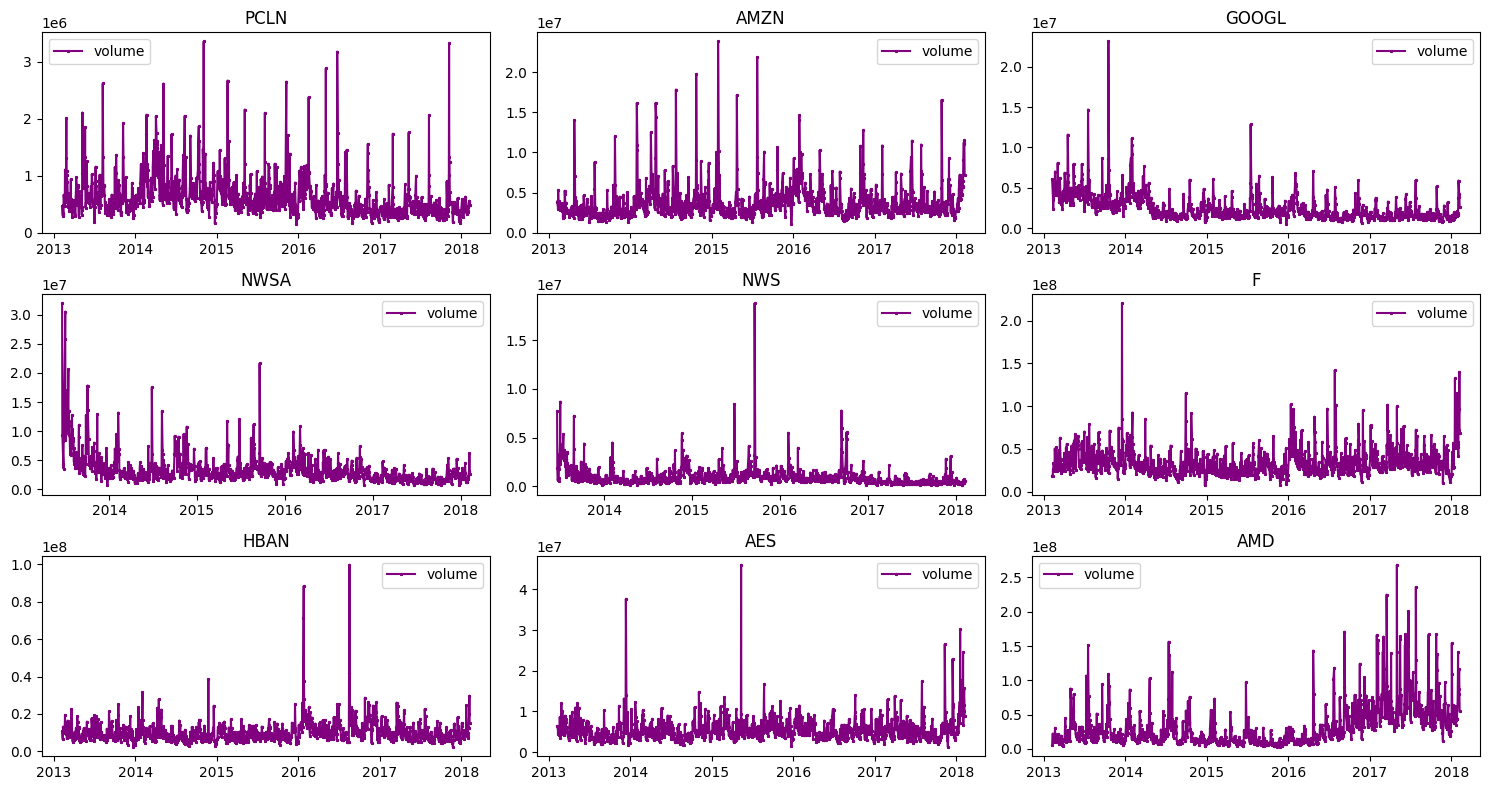

In [7]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies):
    plt.subplot(3, 3, index+1)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['volume'], c="purple", label="volume", marker="*", markersize=2)
    plt.title(company)
    plt.legend()
    plt.tight_layout()

Apple Stock Closing Price from 2013 to 2018

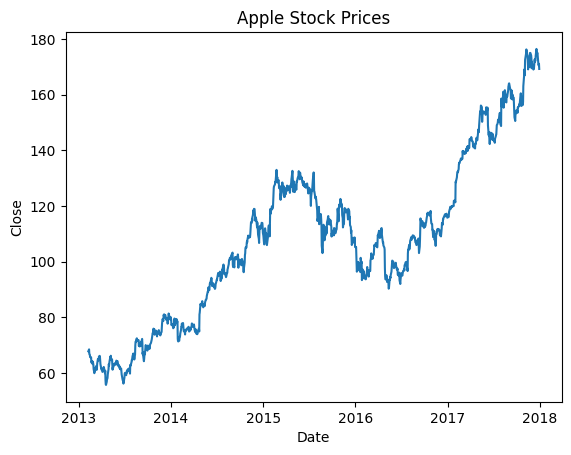

In [8]:
apple = data[data['Name'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1)) & (apple['date'] < datetime(2018,1,1))]
plt.plot(prediction_range['date'], prediction_range['close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Apple Stock Prices')
plt.show()

Split the data for training and validation

In [9]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[:training, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))    

### Build Gated RNN- LSTM network

LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To stack multiple LSTM in TensorFlow we use return_sequences = True. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node.

In [11]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print(x_train, y_train)

[[[0.0977103 ]
  [0.103438  ]
  [0.08951884]
  ...
  [0.06362512]
  [0.06878507]
  [0.08119942]]

 [[0.103438  ]
  [0.08951884]
  [0.08848863]
  ...
  [0.06878507]
  [0.08119942]
  [0.07882556]]

 [[0.08951884]
  [0.08848863]
  [0.08800268]
  ...
  [0.08119942]
  [0.07882556]
  [0.08482135]]

 ...

 [[0.8061069 ]
  [0.82360102]
  [0.84279595]
  ...
  [0.91722692]
  [0.8998138 ]
  [0.90969474]]

 [[0.82360102]
  [0.84279595]
  [0.85696942]
  ...
  [0.8998138 ]
  [0.90969474]
  [0.9452499 ]]

 [[0.84279595]
  [0.85696942]
  [0.85170499]
  ...
  [0.90969474]
  [0.9452499 ]
  [0.95942337]]] [0.07882556 0.08482135 0.07664123 ... 0.9452499  0.95942337 0.96395889]


### Model Compilation and Training

In [12]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=20)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0538
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0090
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0072
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0082
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0082
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0072
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0064
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0073
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0059
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0066
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0079
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0061
Epoch 13/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0051
Epoch 14/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0059
Epoch 15/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0051
Epoc

In [13]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
MSE 111.95191904002732
RMSE 10.580733388571291


### Visualize the data

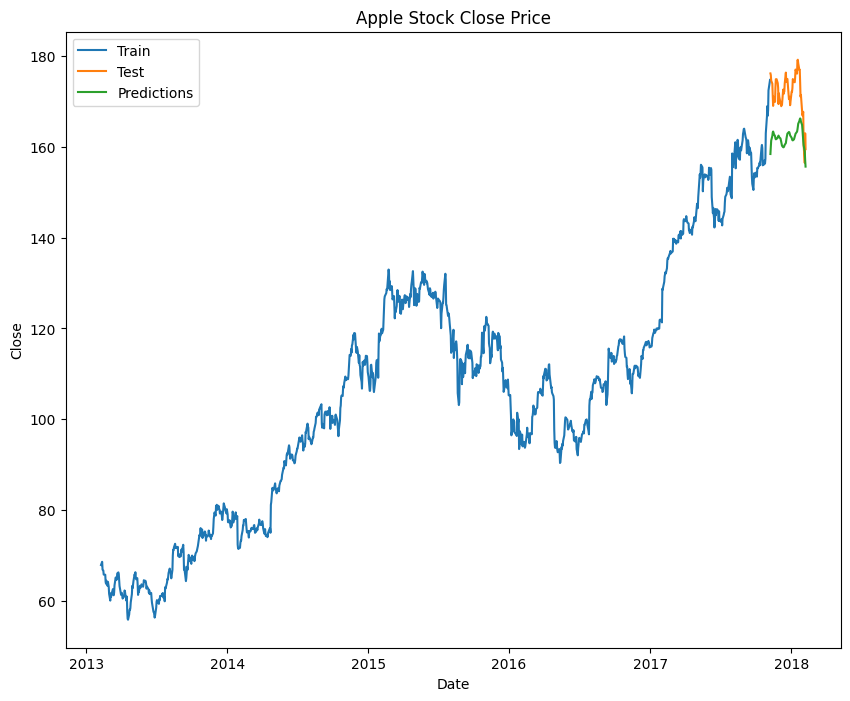

In [14]:
train = apple[:training]
test = apple[training:]
test['predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train', 'Test', 'Predictions'])